# Linear Regression Analysis

In this file we will be continuing our analysis of the housing dataset. In order to improve the model there will be a few additional changes to the EDA process, as well as an analysis of the features to move down the number of features involved. Finally, there will be a different model trained.

In [1]:
# Import the nessesary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import PredictionError
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
!wget https://raw.githubusercontent.com/hixtape1212/Group1Capstone/Gerardo/Austin_notebooks/austinHousingData.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
file_path = 'Austin_notebooks/austinHousingData.csv'
df = pd.read_csv(file_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15171 entries, 0 to 15170
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zpid                        15171 non-null  int64  
 1   city                        15171 non-null  object 
 2   streetAddress               15171 non-null  object 
 3   zipcode                     15171 non-null  int64  
 4   description                 15171 non-null  object 
 5   latitude                    15171 non-null  float64
 6   longitude                   15171 non-null  float64
 7   propertyTaxRate             15171 non-null  float64
 8   garageSpaces                15171 non-null  int64  
 9   hasAssociation              15171 non-null  bool   
 10  hasCooling                  15171 non-null  bool   
 11  hasGarage                   15171 non-null  bool   
 12  hasHeating                  15171 non-null  bool   
 13  hasSpa                      151

In [5]:
#Let's look at the home types. We primarily only want single family homes
df.homeType.value_counts()

Single Family            14241
Condo                      470
Townhouse                  174
Multiple Occupancy          96
Vacant Land                 83
Residential                 37
Apartment                   37
Mobile / Manufactured       17
MultiFamily                 10
Other                        6
Name: homeType, dtype: int64

In [6]:
df = df[df.homeType == 'Single Family']
df.shape

(14241, 47)

In [7]:
#Drop object columns as well as zipid
col_drop_list = df.select_dtypes(include=[np.object]).keys()
col_drop_list = col_drop_list.union(['zpid'])
df = df.drop(col_drop_list, axis=1)
df.shape

C:\Users\gyanezarvizu\AppData\Local\Temp\ipykernel_1284\1663181986.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col_drop_list = df.select_dtypes(include=[np.object]).keys()


(14241, 39)

In [8]:
#Changing Booleans to int values
col_bool_list = ['hasAssociation', 'hasCooling',
                 'hasGarage', 'hasHeating', 'hasSpa', 'hasView']

for col in col_bool_list:
    name = col + '_int'
    df[name] = df[col].astype(int)

df = df.drop(col_bool_list, axis=1)
df.shape

(14241, 39)

In [9]:
#Lets look at the home prices we are predicting
df.describe().transpose().apply(lambda x: x.apply('{0:f}'.format))

,count,mean,std,min,25%,50%,75%,max
zipcode,14241.000000,78736.186785,18.721340,78617.000000,78727.000000,78739.000000,78749.000000,78759.000000
latitude,14241.000000,30.291740,0.098383,30.085030,30.201195,30.284163,30.367920,30.517174
longitude,14241.000000,-97.780411,0.085880,-98.022057,-97.841804,-97.771988,-97.718689,-97.569504
propertyTaxRate,14241.000000,1.994731,0.054207,1.980000,1.980000,1.980000,1.980000,2.210000
garageSpaces,14241.000000,1.236851,1.343474,0.000000,0.000000,1.000000,2.000000,20.000000
parkingSpaces,14241.000000,1.236219,1.343612,0.000000,0.000000,1.000000,2.000000,20.000000
yearBuilt,14241.000000,1988.408749,21.555337,1905.000000,1974.000000,1993.000000,2006.000000,2020.000000
latestPrice,14241.000000,516387.884629,446969.176124,5500.000000,310000.000000,409900.000000,575000.000000,13500000.000000
numPriceChanges,14241.000000,3.044730,2.491960,1.000000,1.000000,2.000000,4.000000,23.000000
latest_salemonth,14241.000000,6.728039,3.134325,1.000000,4.000000,7.000000,9.000000,12.000000


From the previous table the price ranges wildly between 5500 and 13Milion. Now let's see the plot.

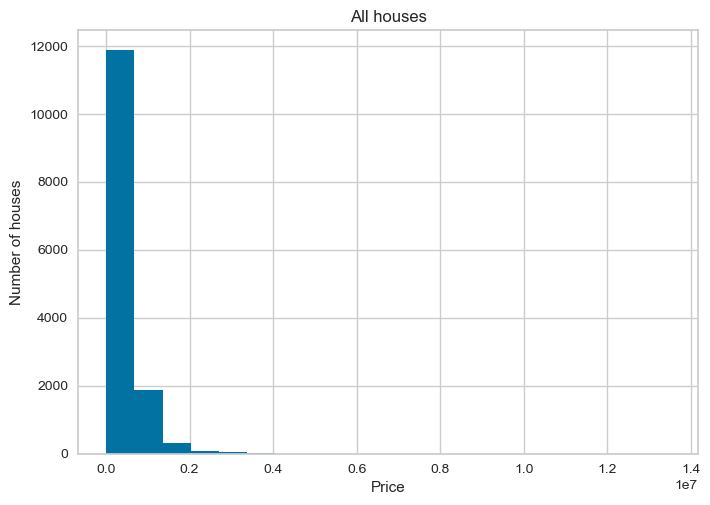

In [10]:
# Plot latestPrice distribution
plt.hist(df['latestPrice'], bins=20)
plt.xlabel('Price')
plt.ylabel('Number of houses')
plt.title('All houses')
plt.show()

In [11]:
#Narrowing this down can help our model. Lets look at the mid 5 & 95%
upper = np.percentile(df.latestPrice, 95)
lower = np.percentile(df.latestPrice, 5)

print('Middle 90 are values between {} and {}'.format(lower, upper))

Middle 90 are values between 207000.0 and 1175000.0


The middle 95% of the home values are between 207,000 and 1,175,000. If we move the lower bound down I think we should be looking at home from 200,000 to 1.1 million, covering roughly 95% of our data

In [12]:
df = df.drop(df[df['latestPrice'] < 200000].index)
df = df.drop(df[df['latestPrice'] > 1175000].index)
df.shape

(12907, 39)

## Analysis


#### Display distribution

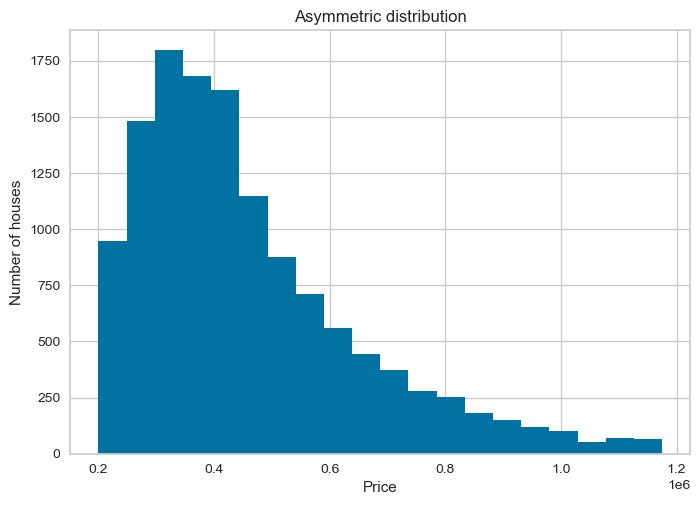

In [13]:
# Plot latestPrice distribution
plt.hist(df['latestPrice'], bins=20)
plt.xlabel('Price')
plt.ylabel('Number of houses')
plt.title('Asymmetric distribution')
plt.show()

## Looking at potential additional Outliers in Features

In [14]:
def value_counts_for_dataframe(df):
    column_value_counts = {}
    for col in df.columns:
        column_value_counts[col] = df[col].value_counts()
    return column_value_counts

# Example usage:
if __name__ == "__main__":
    # Assuming you have a pandas DataFrame called 'your_dataframe'
    # Replace this with your actual DataFrame
    your_dataframe = pd.DataFrame({
        'Column1': [1, 2, 3, 1, 2],
        'Column2': ['A', 'B', 'C', 'A', 'A'],
        'Column3': [True, False, True, False, True]
    })

    # Get value counts for each column in the DataFrame
    result = value_counts_for_dataframe(df)

    # Print the value counts for each column
    for col, value_counts in result.items():
        print(f"Value counts for {col}:")
        print(value_counts)
        print()

Value counts for zipcode:
78748    1056
78745     932
78749     755
78739     600
78737     595
78732     544
78717     502
78759     501
78723     471
78757     465
78704     453
78727     389
78744     380
78753     375
78731     373
78747     349
78754     340
78702     334
78758     334
78750     302
78729     299
78735     224
78728     205
78721     204
78724     179
78726     173
78730     171
78733     158
78736     155
78741     152
78751     149
78703     142
78752     127
78756     113
78746      92
78725      91
78722      90
78617      38
78660      34
78705      32
78619      11
78734       5
78652       4
78742       3
78719       2
78653       2
78738       1
78701       1
Name: zipcode, dtype: int64

Value counts for latitude:
30.179701    4
30.196487    4
30.179668    4
30.375725    3
30.354153    3
            ..
30.194519    1
30.186815    1
30.157265    1
30.166956    1
30.276930    1
Name: latitude, Length: 12336, dtype: int64

Value counts for longitude:
-97.7286

In [15]:
def drop_rows_containing_values(df, column_name, values_to_drop):
    return df[~df[column_name].isin(values_to_drop)]

In [16]:
# Dropping outliers in zipcode
df = drop_rows_containing_values(df, 'zipcode', [78734, 78652, 78719, 78653, 78738, 78701]) #[78734, 78652, 78742, 78719, 78653, 78738, 78701]
df.shape

(12892, 39)

In [17]:
# Dropping Price Change outliers
df = drop_rows_containing_values(df, 'numPriceChanges', [17, 19, 18, 23, 22, 20])
df.shape

(12877, 39)

In [18]:
# Dropping appliance outliers
df = drop_rows_containing_values(df, 'numOfAppliances', [10,54])
df.shape

(12876, 39)

In [19]:
# Dropping Parking Features outliers
df = drop_rows_containing_values(df, 'numOfParkingFeatures', [6,5])
df.shape

(12855, 39)

In [20]:
# Dropping Patio Features outliers
df = drop_rows_containing_values(df, 'numOfPatioAndPorchFeatures', [6,7,8])
df.shape

(12848, 39)

In [21]:
# Dropping Security Features outliers
df = drop_rows_containing_values(df, 'numOfSecurityFeatures', [5,6])
df.shape

(12832, 39)

In [22]:
# Dropping Water front outliers
df = drop_rows_containing_values(df, 'numOfWaterfrontFeatures', [2])
df.shape

(12831, 39)

In [23]:
# Dropping primary schools number outliers
df = drop_rows_containing_values(df, 'numOfPrimarySchools', [0,2])
df.shape

(12133, 39)

In [24]:
# Dropping num of elementary schools outliers
df = drop_rows_containing_values(df, 'numOfElementarySchools', [1,2])
df.shape

(12133, 39)

In [25]:
# Dropping Middle School outliers
df = drop_rows_containing_values(df, 'numOfMiddleSchools', [2,3,0])
df.shape

(12128, 39)

In [26]:
# Dropping Students per teacher outliers
df = drop_rows_containing_values(df, 'MedianStudentsPerTeacher', [10,19])
df.shape

(12087, 39)

## Final Pre-Processing

Lineal regression needs a symetric distribution and we will apply a logarithmic function for this, in other hand Neural network doesn't need a symmetric distribution, with a normalization it's enough. Different models need different processing.

## Linear Regression

As we can see in the plot above we have an asymmetric distribution and to fix it we'll apply a logarithmic function

In [27]:
# Applying logarithmic funtion
transformer = FunctionTransformer(np.log1p, validate=True)
df_log = transformer.transform(df)

C:\Users\gyanezarvizu\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
C:\Users\gyanezarvizu\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:205: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


In [28]:
# Making a new dataframe with logarithmic data
columns_names = df.columns

df_log = pd.DataFrame(df_log, columns= columns_names)
df_log.head(3)

,zipcode,latitude,longitude,propertyTaxRate,garageSpaces,parkingSpaces,yearBuilt,latestPrice,numPriceChanges,latest_salemonth,...,MedianStudentsPerTeacher,numOfBathrooms,numOfBedrooms,numOfStories,hasAssociation_int,hasCooling_int,hasGarage_int,hasHeating_int,hasSpa_int,hasView_int
0,11.272903,3.447783,NaN,1.091923,1.098612,1.098612,7.607381,12.628070,1.791759,2.302585,...,2.70805,1.386294,1.609438,1.098612,0.693147,0.693147,0.693147,0.693147,0.0,0.0
1,11.272903,3.447848,NaN,1.091923,1.098612,1.098612,7.607878,12.594734,0.693147,2.397895,...,2.70805,1.098612,1.609438,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0
2,11.272903,3.447830,NaN,1.091923,1.098612,1.098612,7.607878,12.388398,1.609438,2.197225,...,2.70805,1.098612,1.386294,0.693147,0.693147,0.693147,0.693147,0.693147,0.0,0.0


 Column 'longitude' has negative numbers, after applying the logarithmic function data became NaN, so we have to delete it

In [29]:
# Delete longitude column
df_log = df_log.drop('longitude', axis=1)

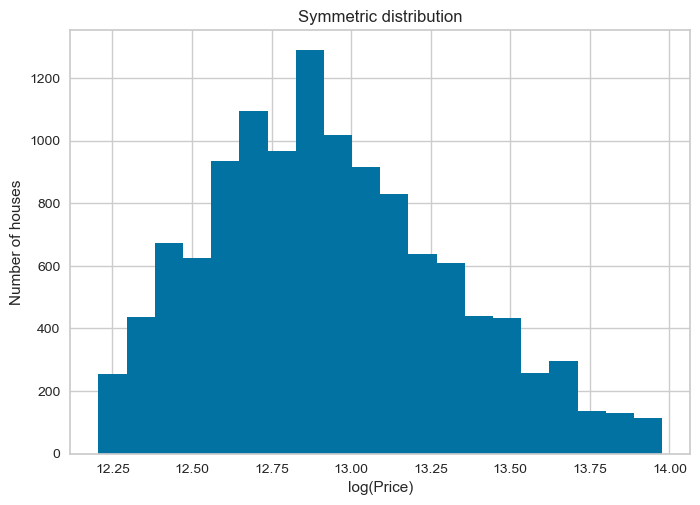

In [30]:
# Plot latestPrice distribution
plt.hist(df_log['latestPrice'], bins=20)
plt.xlabel('log(Price)')
plt.ylabel('Number of houses')
plt.title('Symmetric distribution')
plt.show()

#### Let's see if we have multicollinearity

In [31]:
# Correlation with latestPrice column
df_log.corr()['latestPrice']

zipcode                      -0.192768
latitude                      0.124733
propertyTaxRate              -0.043090
garageSpaces                  0.140420
parkingSpaces                 0.140011
yearBuilt                    -0.069267
latestPrice                   1.000000
numPriceChanges               0.026006
latest_salemonth              0.060737
latest_saleyear               0.088908
numOfPhotos                   0.105452
numOfAccessibilityFeatures    0.016075
numOfAppliances               0.040007
numOfParkingFeatures          0.100818
numOfPatioAndPorchFeatures    0.121177
numOfSecurityFeatures         0.086872
numOfWaterfrontFeatures       0.019980
numOfWindowFeatures           0.117525
numOfCommunityFeatures        0.008264
lotSizeSqFt                   0.366294
livingAreaSqFt                0.523123
numOfPrimarySchools                NaN
numOfElementarySchools             NaN
numOfMiddleSchools                 NaN
numOfHighSchools             -0.167361
avgSchoolDistance        

We dont have multicollinearity

In [32]:
# Delete columns with NaN and features with lowest correlation
df_log = df_log.drop(['numOfElementarySchools','numOfPrimarySchools','numOfMiddleSchools','parkingSpaces','hasCooling_int'
                     ,'hasHeating_int'], axis=1)

In [33]:
# We reduce to 32 features
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12087 entries, 0 to 12086
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   zipcode                     12087 non-null  float64
 1   latitude                    12087 non-null  float64
 2   propertyTaxRate             12087 non-null  float64
 3   garageSpaces                12087 non-null  float64
 4   yearBuilt                   12087 non-null  float64
 5   latestPrice                 12087 non-null  float64
 6   numPriceChanges             12087 non-null  float64
 7   latest_salemonth            12087 non-null  float64
 8   latest_saleyear             12087 non-null  float64
 9   numOfPhotos                 12087 non-null  float64
 10  numOfAccessibilityFeatures  12087 non-null  float64
 11  numOfAppliances             12087 non-null  float64
 12  numOfParkingFeatures        12087 non-null  float64
 13  numOfPatioAndPorchFeatures  120

#### Train and Test splits

In [34]:
#Creating Train and Test splits
X = df_log.drop('latestPrice', axis='columns')
y = df_log.latestPrice
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=42)

In [35]:
# Comparing size of X sets
print(X.shape, X_train.shape, X_test.shape)

(12087, 31) (9669, 31) (2418, 31)


## Lineal regression

In [36]:
# Creating the model
lr = LinearRegression()

In [37]:
# Get model results
lr.fit(X_train, y_train)

LinearRegression()

In [38]:
# Apply model in X_test
prediction_test_lr = lr.predict(X_test)

#### Evaluation

In [39]:
# MAE
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(np.expm1(y_test), np.expm1(prediction_test_lr)), 3)))
# R^2
print('R^2: {}'.format(round(r2_score(y_test, prediction_test_lr), 2)))

Mean Absolute Error: 82041.516
R^2: 0.61


* Our model is off by about 82,041 dollars in a given prediction
* This model is explaining only the 61% of data

#### Plot
Comparison between the actual data from the dataset and the predicted values generated by our model.

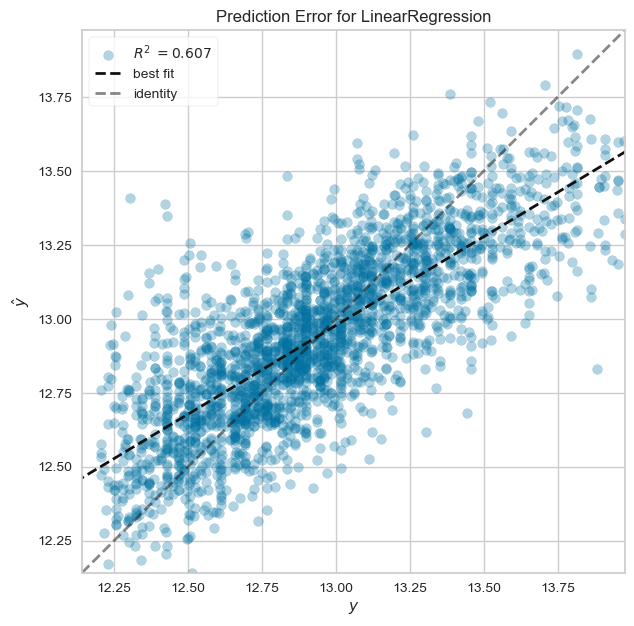

In [40]:
# Prediction Error for our model: 
fig, ax = plt.subplots(figsize=(7,8)) # size plot
visualizer = PredictionError(lr, alpha=0.3) # instantiate visualizer

visualizer.score(X_test, y_test) # Evaluate the model on the test data
visualizer.show() # Finalize and render the figure

plt.show()

## Desicion tree

In [41]:
# Initializing model
dtr = DecisionTreeRegressor(random_state = 42, max_depth=9)

In [42]:
# Train model
dtr.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=9, random_state=42)

In [43]:
# Testing X_test
prediction_test_dtr = dtr.predict(X_test)

#### Evaluation

In [44]:
# MAE
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(np.expm1(y_test), np.expm1(prediction_test_dtr)), 3)))
# R^2
print('R^2: {}'.format(round(r2_score(y_test, prediction_test_dtr), 2)))

Mean Absolute Error: 69483.039
R^2: 0.7


* Our model is off by about 69,483 dollars in a given prediction
* This model is explaining only the 70% of data

#### Plot
Comparison between the actual data from the dataset and the predicted values generated by our model.

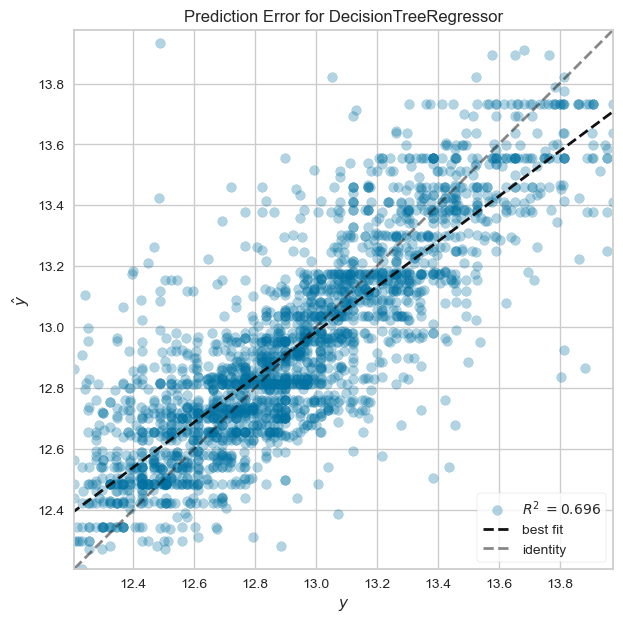

In [45]:
# Prediction Error for our model
fig, ax = plt.subplots(figsize=(7,7)) # size plot
visualizer = PredictionError(dtr, alpha=0.3) # instantiate visualizer

visualizer.score(X_test, y_test) # Evaluate the model on the test data
visualizer.show() # Finalize and render the figure
plt.show()

#### Cross validation
Now to be sure that our model is not overfitting, we will apply cross validation with 5 splits.

In [46]:
# Split data in five slides
cv = KFold(n_splits = 5, shuffle = True)

#Apply cross validation
accuracy_cross_val_r2 = cross_val_score(estimator = dtr,
                                       X = X_train,
                                       y = y_train,
                                       scoring = 'r2',
                                       cv = cv)
print('Accuracy mean r2: {}'.format(round(accuracy_cross_val_r2.mean(), 3)))

Accuracy mean r2: 0.67


## Random forest

In [47]:
# Initializing model
rf = RandomForestRegressor(random_state=42, max_depth=9, n_estimators=50)

In [48]:
# Train model
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, n_estimators=50, random_state=42)

In [49]:
prediction_test_rf = rf.predict(X_test)

#### Evaluation

In [50]:
# MAE
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(np.expm1(y_test), np.expm1(prediction_test_rf)), 3)))
# R^2
print('R^2: {}'.format(round(r2_score(y_test, prediction_test_rf), 2)))

Mean Absolute Error: 60065.53
R^2: 0.77


* Our model is off by about 60,065 dollars in a given prediction
* This model is explaining only the 77% of data

#### Plot
Comparison between the actual data from the dataset and the predicted values generated by our model.

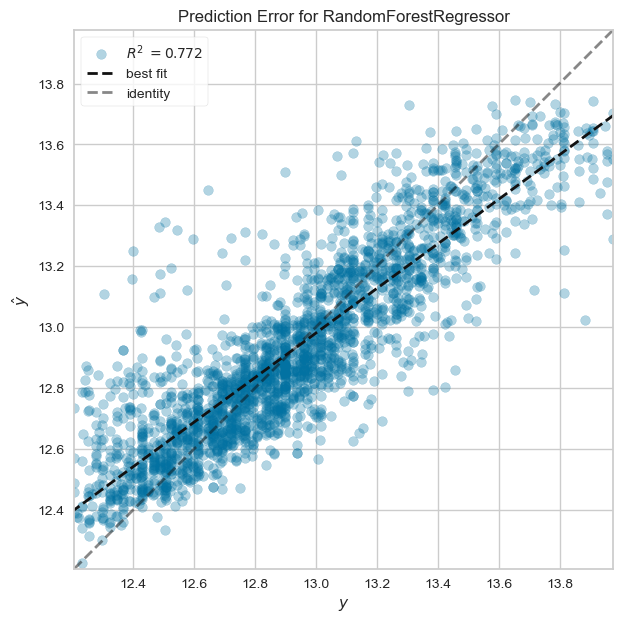

In [51]:
# Prediction Error for our model
fig, ax = plt.subplots(figsize=(7,7)) # size plot
visualizer = PredictionError(rf, alpha=0.3) # instantiate visualizer

visualizer.score(X_test, y_test) # Evaluate the model on the test data
visualizer.show() # Finalize and render the figure
plt.show()

#### Cross validation
Now to be sure that our model is not overfitting, we will apply cross validation with 5 splits.

In [52]:
#Apply cross validation
accuracyRF_cross_val_r2 = cross_val_score(estimator = rf,
                                       X = X_train,
                                       y = y_train,
                                       scoring = 'r2',
                                       cv = cv)

print('Results: {}'.format(accuracyRF_cross_val_r2))
print('Mean R^2: {}'.format(round(accuracyRF_cross_val_r2.mean(), 3)))

Results: [0.7689239  0.76521723 0.75719238 0.75589466 0.76719602]
Mean R^2: 0.763


## XGBoost Regressor

In [53]:
#import xgboost as xgb
xgbr = XGBRegressor(random_state=42, max_depth=8, n_estimators=40)

In [54]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=40, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [55]:
prediction_test_xgbr = xgbr.predict(X_test)

#### Evaluation

In [56]:
# MAE
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(np.expm1(y_test), np.expm1(prediction_test_xgbr)), 3)))
# R^2
print('R^2: {}'.format(round(r2_score(y_test, prediction_test_xgbr), 3)))

Mean Absolute Error: 55456.75
R^2: 0.798


* Our model is off by about 55,456 dollars in a given prediction
* This model is explaining only the 79.8% of data

#### Plot
Comparison between the actual data from the dataset and the predicted values generated by our model.

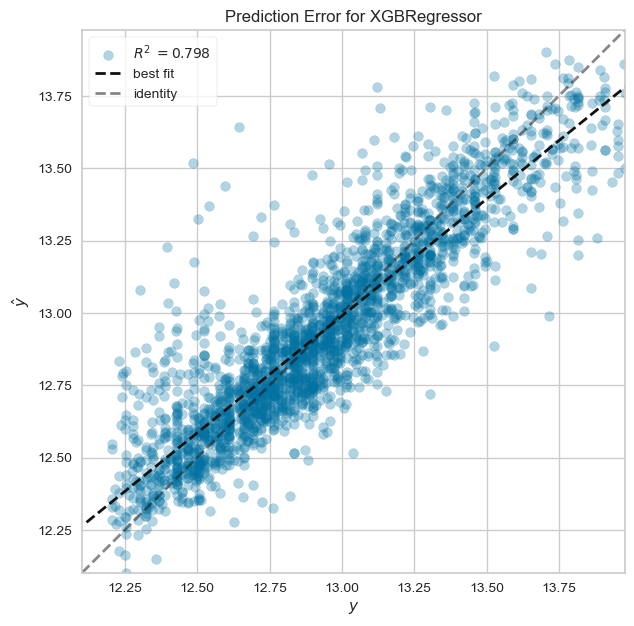

In [57]:
# Prediction Error for our model: XGBRegressor
fig, ax = plt.subplots(figsize=(7,8)) # size plot
visualizer = PredictionError(xgbr, alpha=0.3) # instantiate visualizer

visualizer.score(X_test, y_test) # Evaluate the model on the test data
visualizer.show() # Finalize and render the figure
plt.show()

#### Cross validation
Now to be sure that our model is not overfitting, we will apply cross validation with 5 splits.

In [58]:
#Apply cross validation
accuracyXGBR_cross_val_r2 = cross_val_score(estimator = xgbr,
                                       X = X_train,
                                       y = y_train,
                                       scoring = 'r2',
                                       cv = cv)
print('Results: {}'.format(accuracyXGBR_cross_val_r2))
print('Mean R^2: {}'.format(round(accuracyXGBR_cross_val_r2.mean(), 3)))

Results: [0.7853992  0.77593798 0.78315556 0.78723793 0.79766052]
Mean R^2: 0.786


### In conclusion our better model with the best performance is XGBoost Regressor
* Our model is off by about 55,456 dollars in a given prediction
* This model is explaining only the 79.8% of data

##### Packages to install
* pip install -U yellowbrick
* pip install xgboost